<a href="https://colab.research.google.com/github/bgohrani/Recurrent_Neural_Networks/blob/main/1.RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Designed Architechture for the RNNs 
### Summary of the following code to prevent confusion on how the functions are called within each other


*   First we specify the RNN class and define the functions that will run.

*   The init function specifies the sizes and the weights, the hidden function creates the 0th layer of the hidden state, and the forward pass gives the output for a single time step.

*   `train_full_cuda` is called, a loss_array is initialized each unit of which represents the loss on one batch of the data of `batch_size`. Loss Funcion and optimizer are set here.

*   For each batch, `train_one_batch` is called. A batch is generated here by calling `generate_batch`, which returns a list with tuples, of random points of `X_train` and `Y_train`. For each tuple within the list, the first point is a word, and `forward_pass` is called for each letter. The output of the last layer is returned and the `loss_func` is called for that word. The losses of all the words are added and the optimizer is called to update the weights. This total loss for all the words within the batch is returned.

*   Back to the `train_full` function, each unit is the sum of all the losses of all batches before it, divided by the index of that unit.

*  Top-1 and Top-2 accuracies are calculated by calling the `accuracy_on_model` function. A batch of the same batch size is generated by calling the `generate_data` function and each word is passed through the network by calling the `thru_RNN` function. The difference here is that the model is put into the  `.eval()` mode. Letters are passed in the same way and the output tensor is returned. A count of the (correctly predicted letters/batch_size) is returned.

*   This brings us to the end of the `train_full` function. 


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , mean_squared_error
import matplotlib.colors
import math
from sklearn.datasets import make_blobs
from sklearn.compose import ColumnTransformer
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import time
sns.set()
import torchvision.models as models
import copy
import torchvision
from torchvision.transforms import transforms
import os
import sys
import string

#importing essential libraries

In [ ]:
device = torch.device('cuda')

#Setting the GPU 

In [ ]:
X = []
Y = []
data = []
languages = []

with open ('name2lang.txt') as file:
  for entry in file:
    name, nation = entry.split(',')
    nation = nation.strip()
    X.append(name)
    Y.append(nation)
    if not nation in languages:
      languages.append(nation)
    data.append((name, nation))

#We have a data file wherein different names are classified into different languages
#We loop through the file and first separate out the word with the comma delimiter 
#This is followed by removing the extra spaced and adding the X values and their labels, Y
#The different types of languages are stored in the languages file

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify=Y, test_size=0.2, random_state = 0)
print(len(X_train))
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

#We print out the sizes of the data we have created to see if they are consistent

16040
4010
16040
4010


In [ ]:
alphabet = string.ascii_letters + " ,;'"
all_letters = list(alphabet)

#We need to begin encoding our data, so we'll first create a list of all the ACSII characters

In [ ]:
X_train_new = []
X_test_new = []

for word in X_train:
  onehotstart = torch.zeros(len(word),1,len(all_letters))
  for i, letter in enumerate(word):
    index = all_letters.index(letter)
    onehotstart[i][0][index] = 1
  X_train_new.append(onehotstart)

for word in X_test:
  onehotstart = torch.zeros(len(word),1,len(all_letters))
  for i, letter in enumerate(word):
    index = all_letters.index(letter)
    onehotstart[i][0][index] = 1
  X_test_new.append(onehotstart)

#Here we will encode our data, with the one hot encoding approach, we create a 3-D tensor for each word
#The first dimension stores the position of the letter in the word and the third stores a vector of the alphabets with 1 placed where the letter occurs
#Once we have that we loop through the word and for each letter add 1 wherever needed

In [ ]:
print(len(X_train_new))
print(len(X_test_new))

#Encoded data

16040
4010


In [ ]:
X_train_new[0][0].shape

torch.Size([1, 56])

In [ ]:
# Y_train_new = []
# Y_test_new = []

# for word in Y_train:
#   index = languages.index(word)
#   onehotstart = torch.zeros(len(languages))
#   onehotstart[index] = 1
#   Y_train_new.append(onehotstart)


# for word in Y_test:
#   index = languages.index(word)
#   onehotstart = torch.zeros(len(languages))
#   onehotstart[index] = 1
#   Y_test_new.append(onehotstart)

In [ ]:
Y_train_new = []
Y_test_new = []

for word in Y_train:
  index = languages.index(word)
  Y_train_new.append(torch.tensor([index]))


for word in Y_test:
  index = languages.index(word)
  Y_test_new.append(torch.tensor([index]))

#For Y_train and Y_test it is simpler, we just create a list which stores a tensor containing the index value of the letter

In [ ]:
print(len(Y_train_new))
print(len(Y_test_new))

#Encoded ground truths

16040
4010


In [ ]:
languages

#Here we can see what all languages we have to train on

['Portuguese',
 'Irish',
 'Spanish',
 'Vietnamese',
 'Chinese',
 'Greek',
 'Czech',
 'Dutch',
 'Japanese',
 'French',
 'German',
 'Scottish',
 'English',
 'Russian',
 'Polish',
 'Arabic',
 'Korean',
 'Italian']

In [ ]:
plotting_data = {}

for lang in languages:
  plotting_data[lang] = 0
for point in data:
  plotting_data[point[1]] += 1

#We want to study the distribution of data. This is very essential and directly impacts the training
#We find out how many times each language occurs in the data
#We use a dictionary for this 

Text(0.5, 1.0, 'Distribution of Data')

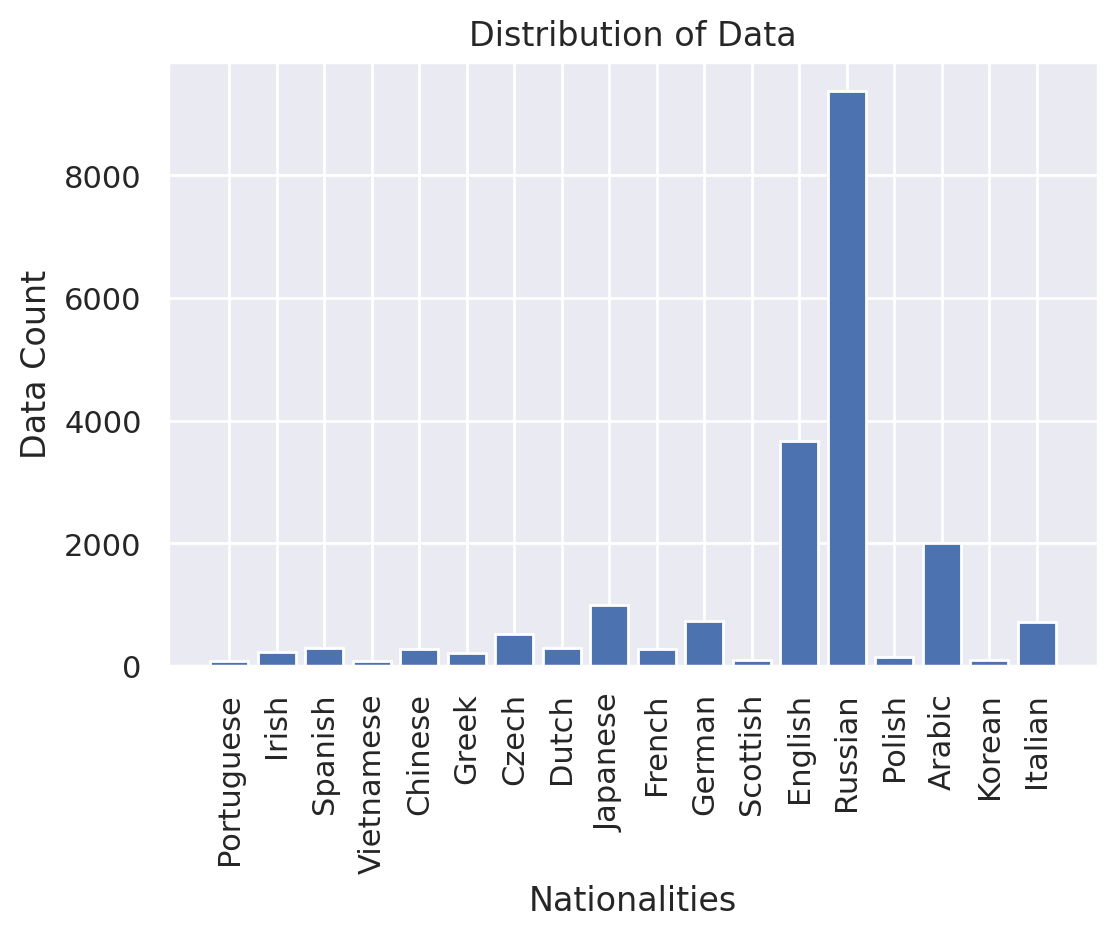

In [ ]:
plt.figure(dpi=200)
plt.bar(list(plotting_data.keys()),list(plotting_data.values()))
plt.xticks(rotation=90)
plt.xlabel('Nationalities')
plt.ylabel('Data Count')
plt.title('Distribution of Data')

#We plot data from the dictionary we have
#OBSERVATION: 
#The distribution data is not uniform
#The samples for Russian are many times higher than the rest
#Our model accuracy will therefore suffer in other languages

In [ ]:
class RNN_1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_1,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.i_t_h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i_t_o = nn.Linear(input_size + hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,hidden_val):
    joined = torch.cat((input_val, hidden_val),dim=1)
    hidden_val_2 = self.i_t_h(joined)
    output_val_2 = self.i_t_o(joined)
    # output_val_2 = self.softmax(output_val_2)
    return output_val_2, hidden_val_2
  

  def new_hidden(self):
    hidden_val = torch.zeros(1,self.hidden_size)
    return hidden_val

#Our first Recurrent Neural Network using PyTorch, image has been shown below
#We create two linear layers, both taking the input and hidden layers concatenated and returning the hidden and output states
#Our forward pass concatenates our first input and the 0th hidden layer(initilized) and passes it simultaneously through the two layers
#Softmax is avoided since we have used Cross-Entropy loss which does softmax internally
#To be clear the network above is just one unit of the image below

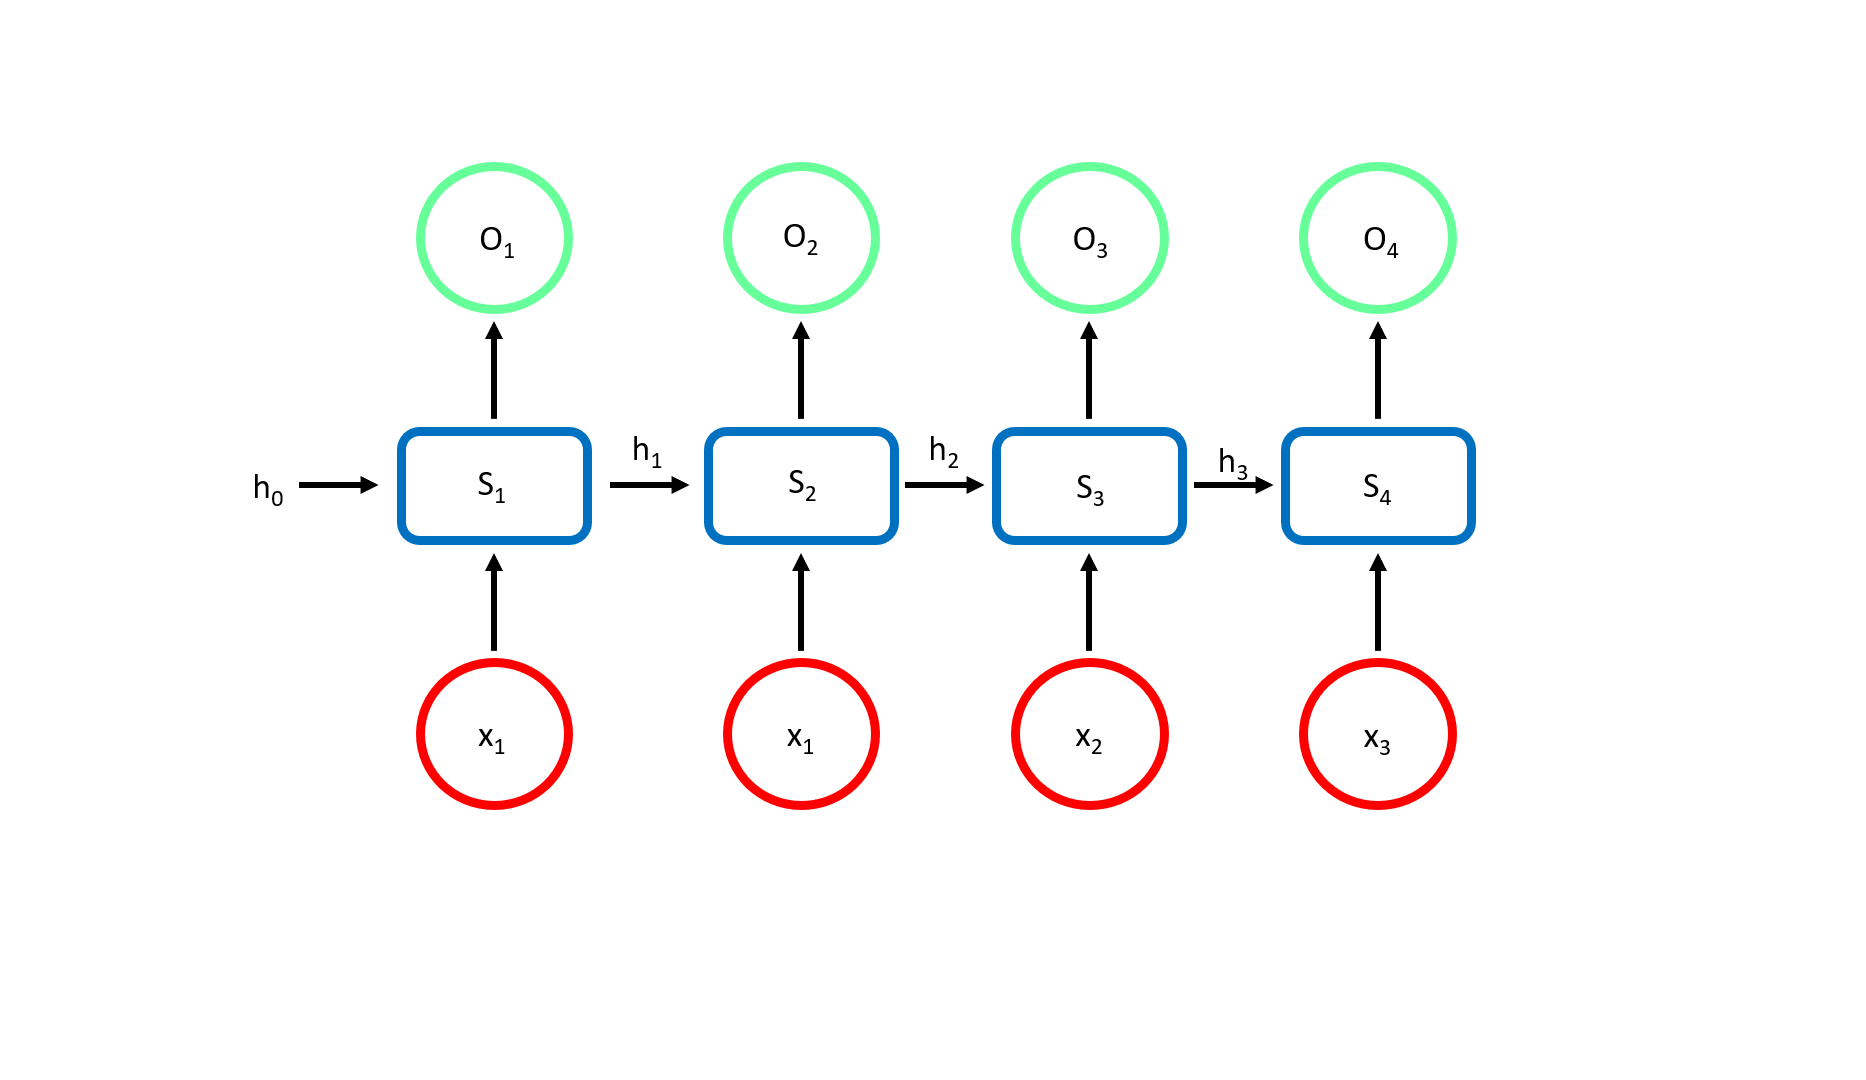

In [ ]:
net = RNN_1(56,128,18)

#We instantiate our class

In [ ]:
def thru_RNN(net,word):
  net.eval()
  hidden = net.new_hidden()

  for letter in word:
    output, hidden = net.forward_pass(letter,hidden)
        
  return output

#We create a function which passes the word through the network
#The outputs are ignored at each step except the last
#Only the hidden state is carried on 
  


def generate_data(points,X,Y,X_orig,Y_orig):
  data = []
  for i in range(points):
    point = np.random.randint(len(X))
    data.append((X[point],Y[point],X_orig[point],Y_orig[point]))
  return data

#From the data we have we need to get some random values so this function helps us do that 
#Input is taken as the number of points needed and a tuple with all values is returned


def accuracy_on_model(model, points, k, X,Y,X_orig,Y_orig):
  data = generate_data(points,X,Y,X_orig,Y_orig)
  count = 0.000

  for datapoint in data:
    model_prediction = thru_RNN(model,datapoint[0])
    _, indices = model_prediction.topk(k)
    for index in indices[0]:
      if index.item() == datapoint[1].item():
        count += 1

  
  calc_accuracy = count/points
  return calc_accuracy

#This is our accuracy function, it takes in the network, the number of samples we want and the data we have 
#Each word is passed through the network, prediction is made and the count of correct values is maintained
#The accuracy is returned at the end
#An additional value called topk is maintained which can allow us to take top 1, 2, 3 or n values for accuracy checking 

In [ ]:
output = thru_RNN(net,X_train_new[0])
index = torch.argmax(output,1).item()
predicted_nation = languages[index]
print(predicted_nation)

#Seeing the prediction our model makes on a given data point

Czech


In [ ]:
accuracy_on_model(net,1000,3,X_train_new,Y_train_new,X_train,Y_train)

0.28

Training on one batch

In [ ]:
def train_one_batch(model, points, loss_func, optimizer):

  optimizer.zero_grad()
  total_loss = 0
  data = generate_data(points,X_train_new,Y_train_new,X_train,Y_train)
  hidden = model.new_hidden()

  for datapoint in data:
    for letter in datapoint[0]:
      output, hidden = model.forward_pass(letter,hidden)
    model_prediction = output
    loss = loss_func(output, datapoint[1])
    total_loss += loss
    loss.backward(retain_graph=True)
    
  clipping_value = 100
  torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)

  optimizer.step()

  return total_loss/points

#To train our RNN, we will proceed in two steps, first we create a function that trains one batch when called
#Then we will make a function that calls this multiple times
#Here we set the optimizer to zero grad and generate datapoints randomly
#The model.new_hidden creates the initial hidden state for the network
#We then loop through the data, get an output, compute loss and backpropagte as in other networks
#We clip the gradients to prevent them from exploding, the typical behaviour when gradients explode is that loss becomes NaN
#We then optimize our weights

In [ ]:
net = RNN_1(56,128,18)

In [ ]:
opt = optim.SGD(net.parameters(),lr = 0.01, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

train_one_batch(net,200,loss_func,opt)

#Here we create the criterion and the optimizer

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


tensor(2.9061, grad_fn=<DivBackward0>)

In [ ]:
print('Training Accuracy: ',accuracy_on_model(net,1000,3,X_train_new,Y_train_new,X_train,Y_train))
print('Test Accuracy: ',accuracy_on_model(net,1000,1,X_test_new,Y_test_new,X_test,Y_test))

#Top-3 accuracy is around 75% and top-1 is around 47
#Our data is not distributed evenly so training is not balanced

Training Accuracy:  0.756
Test Accuracy:  0.473


In [ ]:
#Overall function

def train_full(model, no_batches, batch_size, lr, momentum=0.9):

  loss_array = torch.zeros(no_batches+1)
  loss_array = loss_array.to(device)
  loss_func = nn.CrossEntropyLoss()
  opt = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

  for i in tqdm_notebook(range(no_batches)):
    loss_array[i+1] = (loss_array[i]*i + train_one_batch(model,batch_size,loss_func,opt))/(i+1)
    print('Calculated Accuracy')
    print('Top-1:', accuracy_on_model(model, len(X_test_new),1,X_test_new,Y_test_new,X_test,Y_test))
    print('Top-2:', accuracy_on_model(model, len(X_test_new),2,X_test_new,Y_test_new,X_test,Y_test))
    print('Loss: ', loss_array[i+1].item())
  
  return loss_array

#Here is our final training function, which creates loss arrays where training loss values will be stored
#Criterion is set here, optimizer needs to be since we might want different lr values, it was not mandatory earlier
#So we append the loss array with the loss values returned from a batch called


In [ ]:
net = RNN_1(56,128,18)

In [ ]:
output2 = train_full(net,100,256,0.0005, momentum=0.9)

#Training function called

In [ ]:
plt.figure(dpi=150)
plt.plot(output2.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

#Loss values plotted

In [ ]:
torch.save(net.state_dict(),'Trained_model.pth')

In [ ]:
state_dict = torch.load('Trained_model.pth')
net.load_state_dict(state_dict)
accuracy_on_model(net,len(X_test_new),1,X_test_new,Y_test_new,X_test,Y_test)

#The code above can help us save the model, load it and calculate accuracy
#Top-1 increases to 63%

0.6304239401496259

## LSTMs
Here we study another type of RNN, known as LSTM or Long-Short-Term-Memory cells. In the _vanilla_ RNN, the flow of information loses its originality over time, i.e. information gets morphed since it passes through layers and layers of cells. The predictions therefore, which depend on initial characters in the network are harder to reach. To resolve this, we implement what is known as a LSTM cell, in which the flow of information is regulated through different gates as seen in the diagram below. The LSTM outputs a cell state along with the hidden state which passes on to the next cell.

In the diagram, the three sigmoid units show three gates that are generated. The previous cell state is acted on by the first gate to generate an intermediate state. From the other two gates, one works on the input and forms the final cell state and the other works on the intermediate cell state to form the next hidden state.
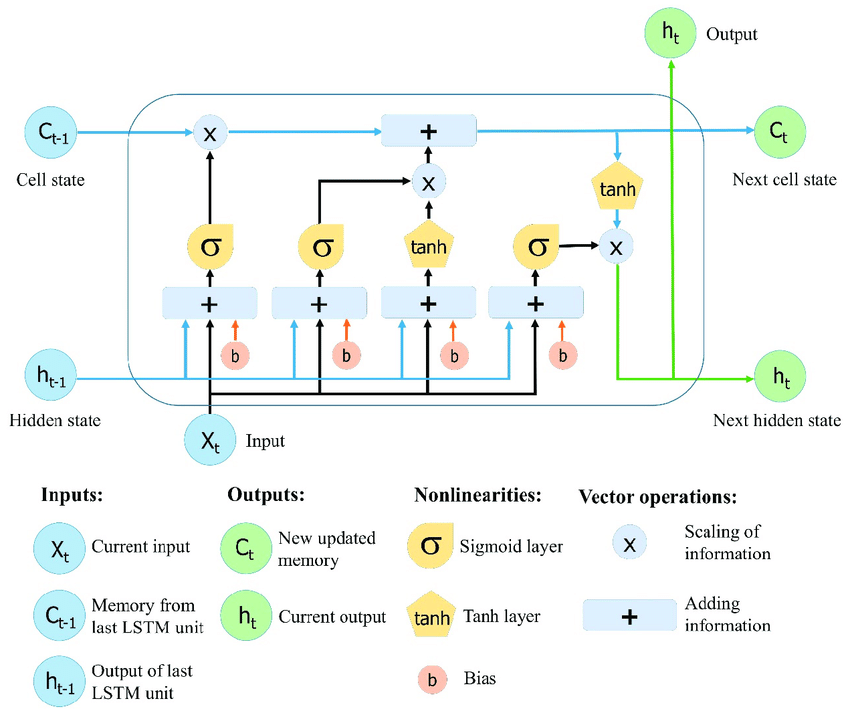

In [ ]:
class LSTM_1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM_1,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.do_lstm = nn.LSTM(input_size,hidden_size)
    self.i_t_o = nn.Linear(hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,h_state_s_state):
    output, h_state_s_state = self.do_lstm(input_val.view(1,1,-1),h_state_s_state)
    output_val = self.i_t_o(h_state_s_state[0])
    # output_val_2 = self.softmax(output_val_2)
    return output_val.view(1,-1), h_state_s_state

  def new_hidden(self):
    return (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))

#This is our RNN with the LSTM implemented
#With PyTorch we dont need to code the cell, we can just call it with one line of code 
#In the forward pass, we get a h_state and an additional c_state besides the output
#The output from the entire cell is created by passing the hidden state through a linear layer
#New_hidden helps us make the initial hidden and cell states


In [ ]:
net_lstm = LSTM_1(56,128,18)

#Instantiating

In [ ]:
output3 = train_full(net_lstm,15,256,0.0005,0.9)

#Training with the same functions earlier

In [ ]:
plt.figure(dpi=150)
plt.plot(output3.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

#Plotting the loss values in training

In [ ]:
torch.save(net_lstm.state_dict(),'Trained_model_LSTM.pth')

In [ ]:
state_dict = torch.load('Trained_model_LSTM.pth')
net_lstm.load_state_dict(state_dict)
accuracy_on_model(net_lstm,len(X_test_new),2,X_test_new,Y_test_new,X_test,Y_test)

#Saving and loading

0.6468827930174563

## GRU
The GRU cell is a little simpler compared to the LSTM. Here, there are only two gates, one which acts upon the incoming hidden state to generate an intermediate state and the other which acts on the incoming previous state and is joined by the intermediate state to produce the next state. 
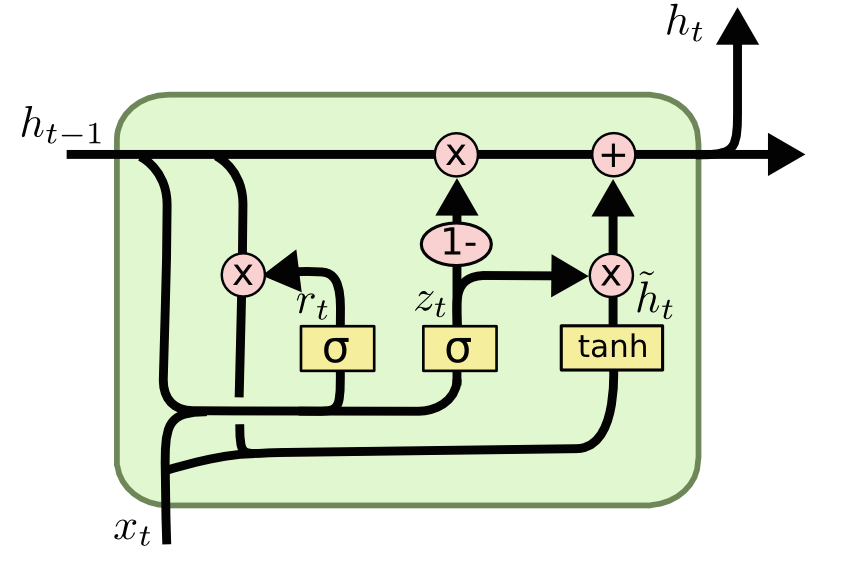

In [ ]:
class GRU_1(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRU_1,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.do_gru = nn.GRU(input_size,hidden_size)
    self.i_t_o = nn.Linear(hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,h_state):
    output, h_state = self.do_gru(input_val.view(1,1,-1),h_state)
    output_val = self.i_t_o(h_state[0])
    # output_val_2 = self.softmax(output_val_2)
    return output_val.view(1,-1), h_state

  def new_hidden(self):
    return torch.zeros(1,1,self.hidden_size)
  
#Creating the GRU cell with PyTorch, not much difference
    

In [ ]:
net_gru = GRU_1(56,128,18)

In [ ]:
output4 = train_full(net_gru,30,256,0.0005,0.9)

In [ ]:
plt.figure(dpi=150)
plt.plot(output4.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
torch.save(net_gru.state_dict(),'Trained_model_GRU.pth')

In [ ]:
state_dict = torch.load('Trained_model_GRU.pth')
net_gru.load_state_dict(state_dict)
accuracy_on_model(net_gru,len(X_test_new),2,X_test_new,Y_test_new,X_test,Y_test)

#Same as earlier

0.6473815461346634

## Plotting Confusion Matrix
This is a form of visualization which shows how confident our network is in predicting outputs. One side of the matrix shows the ground truths and the other shows the predicted values of the network. Values are sent into their cells as per the results of the network. The ideal confusion matrix must be diagonal however we will see that this is not the case here.

In [ ]:
RNN_pred = torch.zeros(len(X_test_new))
for i in range(len(X_test_new)):
  model_pred = thru_RNN(net, X_test_new[i])
  RNN_pred[i] = model_pred.argmax(axis=1)

#We take the predictions of the network on test data

In [ ]:
ground_truths = torch.tensor(Y_test_new)

In [ ]:
print(RNN_pred.shape)
print(ground_truths.shape)

torch.Size([4010])
torch.Size([4010])


In [ ]:
data_conf_matrix = torch.transpose(torch.stack((ground_truths,RNN_pred)),1,0)

#We stack the predicted and actual values to form the data we will use to create

In [ ]:
conf_matrix = torch.zeros([18,18])
for pair in data_conf_matrix:
  row = int(pair[0].item())
  column = int(pair[1].item())
  conf_matrix[row][column] += 1

#We then take the counts of each combination and add it to our matrix

Text(0.5, 1.0, 'Confusion Matrix')

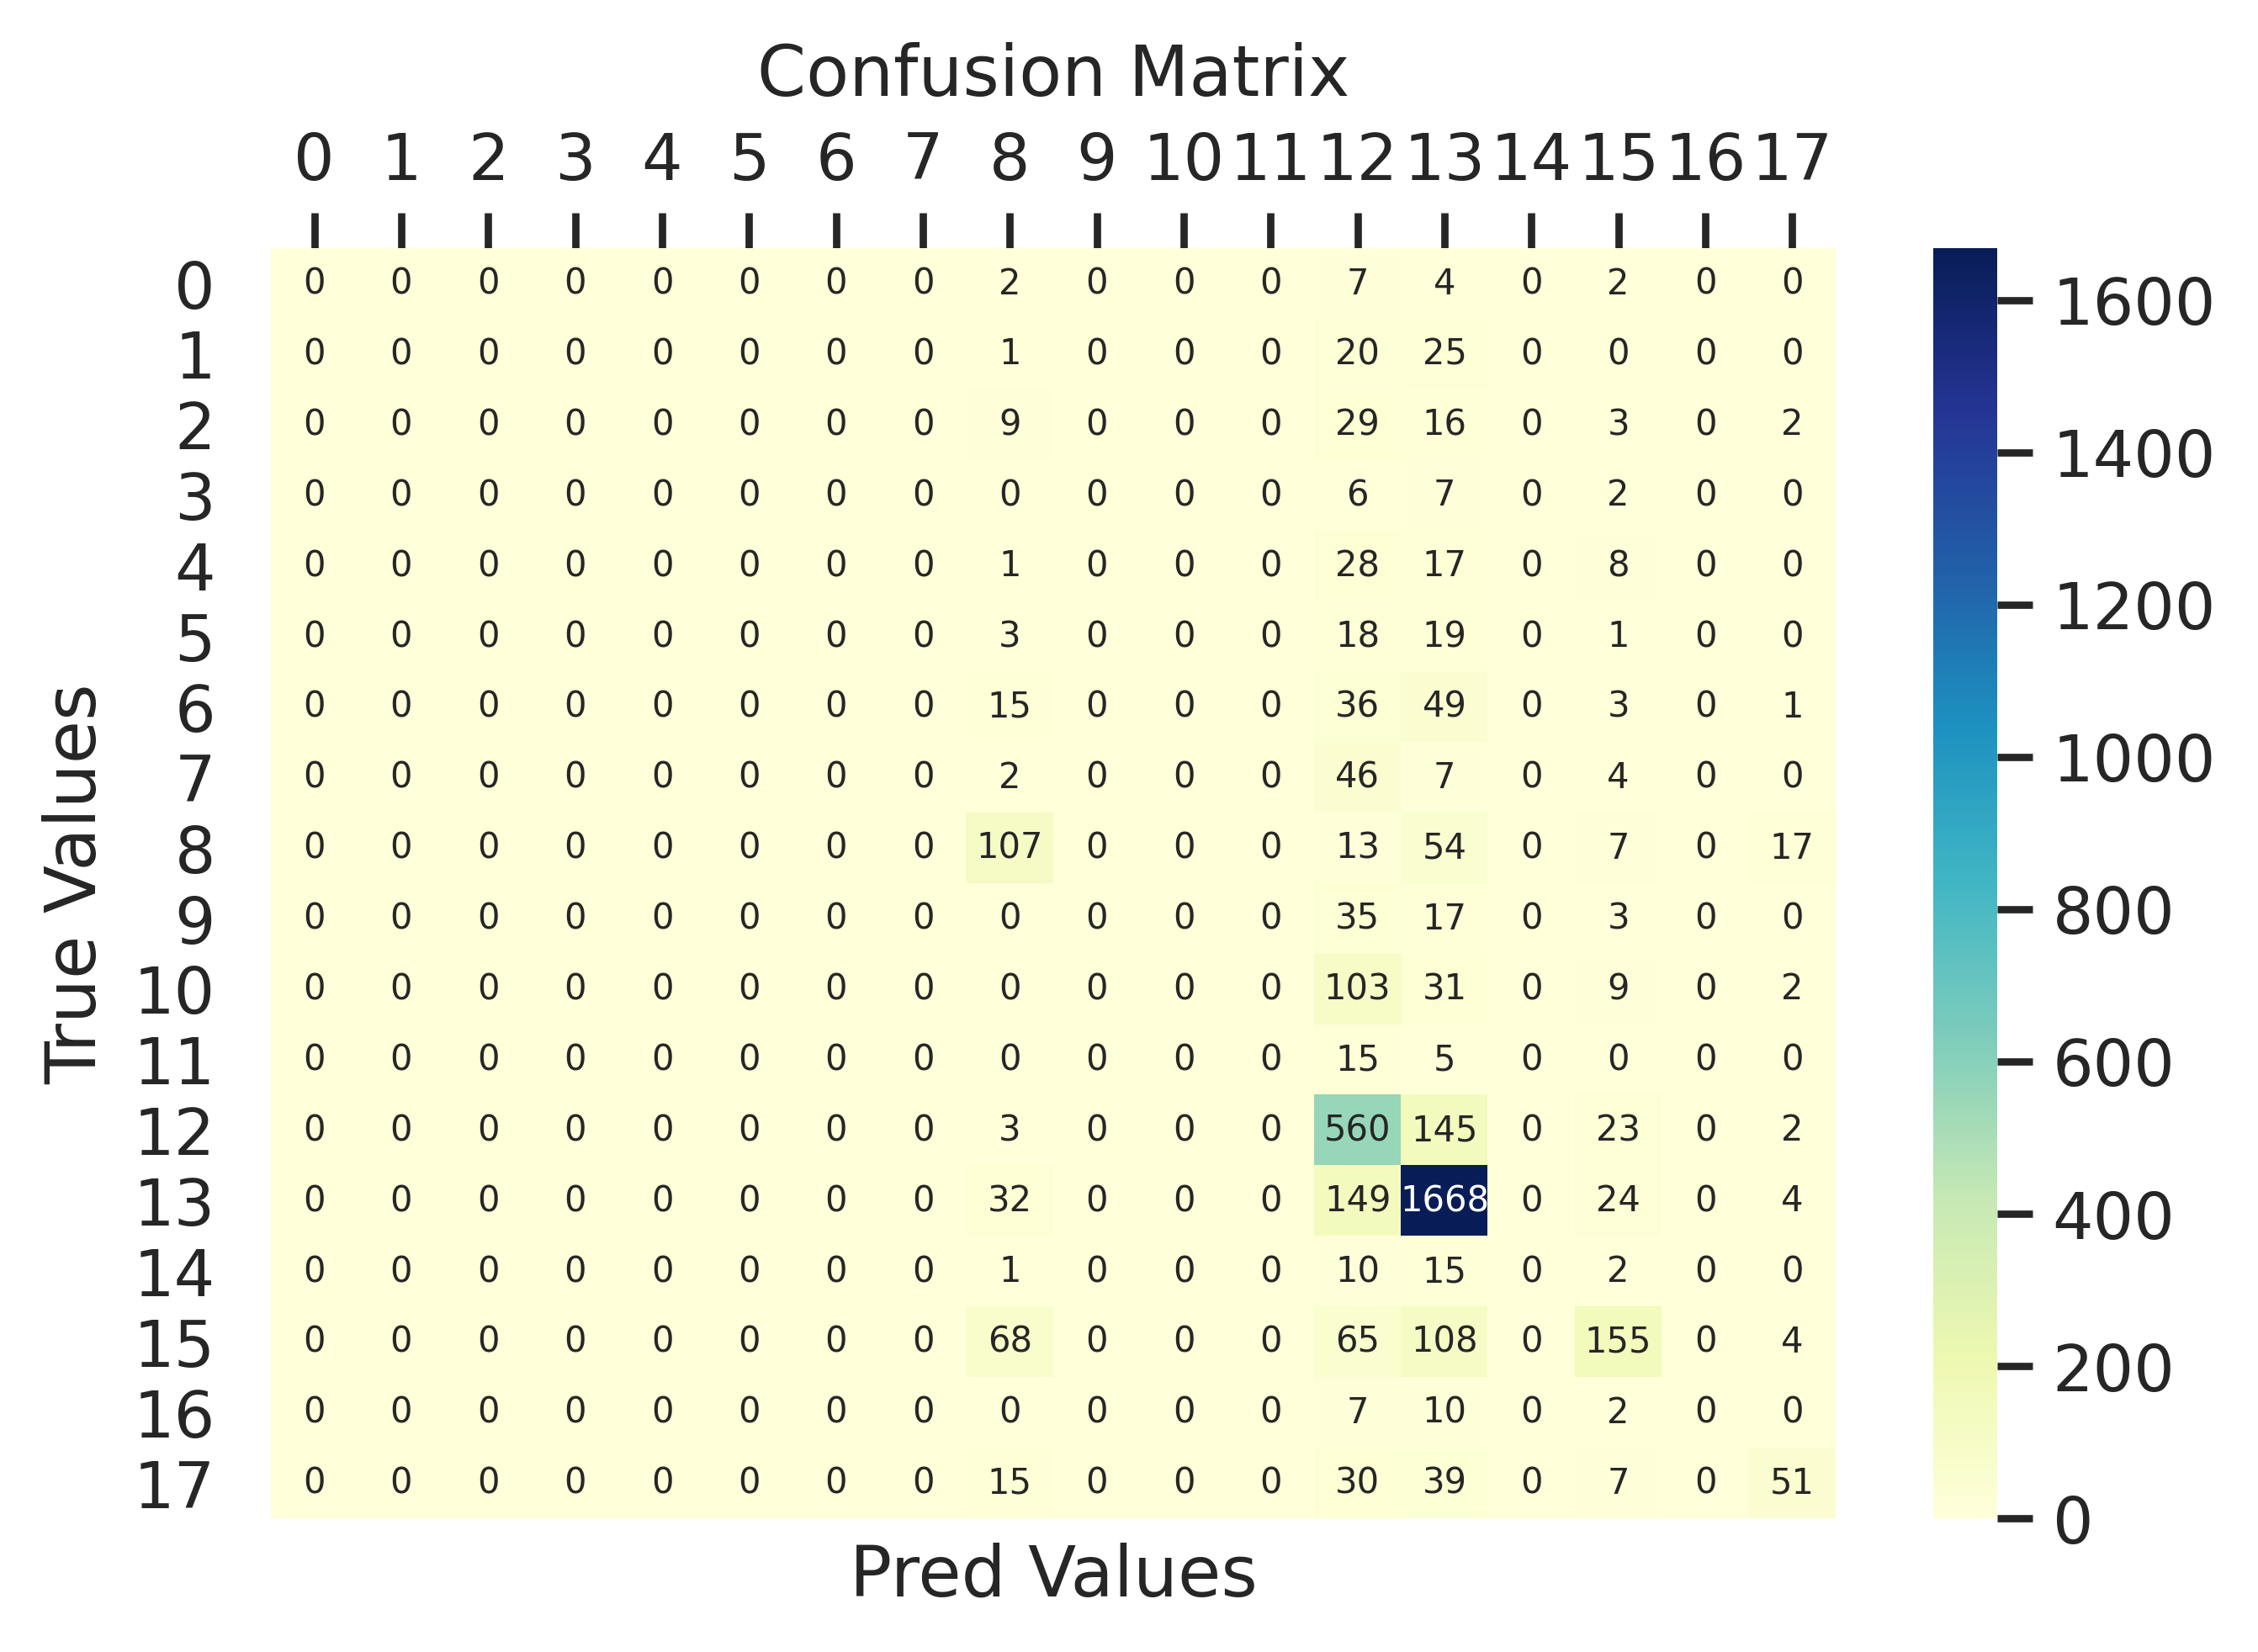

In [ ]:
plt.figure(dpi=500)
cmap = sns.cm.rocket_r
ax = sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,annot_kws={"fontsize":6},fmt='g')
ax.xaxis.set_ticks_position('top')
plt.xlabel('Pred Values')
plt.ylabel('True Values')
plt.title('Confusion Matrix')

#Plotting the confusion matrix
#Poor confusion matrix is largely due to inadequate distribution of the data for different classes

In [ ]:
device = torch.device('cpu')

#Enabling GPU support

In [ ]:
X_train_new_cuda = [data_point.to(device) for data_point in X_train_new]
X_test_new_cuda = [data_point.to(device) for data_point in X_test_new]

#Moving our training data to GPU

In [ ]:
Y_train_new_cuda = [data_point.to(device) for data_point in Y_train_new]
Y_test_new_cuda = [data_point.to(device) for data_point in Y_test_new]

In [ ]:
def thru_RNN_cuda(net,word):
  net.eval()
  hidden = net.new_hidden()

  for letter in word:
    output, hidden = net.forward_pass(letter,hidden)
      
  return output
  


def generate_data_cuda(points,X,Y):
  data = []
  for i in range(points):
    point = np.random.randint(len(X))
    data.append((X[point],Y[point]))
  return data


def accuracy_on_model_cuda(model, points, k, X,Y):
  data = generate_data_cuda(points,X,Y)
  count = 0.000

  for datapoint in data:
    model_prediction = thru_RNN(model,datapoint[0])
    _, indices = model_prediction.topk(k)
    for index in indices[0]:
      if index.item() == datapoint[1].item():
        count += 1

  
  calc_accuracy = count/points
  return calc_accuracy


#Same functions as earlier, will be used for GPU instance

In [ ]:
def train_one_batch_cuda(model, points, loss_func, optimizer):

  optimizer.zero_grad()
  total_loss = 0
  data = generate_data_cuda(points,X_train_new_cuda,Y_train_new_cuda)
  hidden = model.new_hidden()

  for datapoint in data:
    for letter in datapoint[0]:
      output, hidden = model.forward_pass(letter,hidden)
    model_prediction = output
    # print(output.shape)
    # print(datapoint[1])
    loss = loss_func(output, datapoint[1])
    total_loss += loss
    loss.backward(retain_graph=True)
    
  clipping_value = 100
  torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)

  optimizer.step()

  return total_loss/points


def train_full_cuda(model, no_batches, batch_size, lr, momentum=0.9):

  loss_array = torch.zeros(no_batches+1)
  loss_array = loss_array.to(device)
  loss_func = nn.CrossEntropyLoss()
  opt = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

  for i in tqdm_notebook(range(no_batches)):
    loss_array[i+1] = (loss_array[i]*i + train_one_batch_cuda(model,batch_size,loss_func,opt))/(i+1)
    print('Calculated Accuracy')
    print('Top-1:', accuracy_on_model_cuda(model, len(X_test_new_cuda),1,X_test_new_cuda,Y_test_new_cuda))
    print('Top-2:', accuracy_on_model_cuda(model, len(X_test_new_cuda),2,X_test_new_cuda,Y_test_new_cuda))
    print('Loss: ', loss_array[i+1].item())
  
  return loss_array

#Single batch and full training functions same as earlier


In [ ]:
class RNN_1_Cuda(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_1_Cuda,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.i_t_h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i_t_o = nn.Linear(input_size + hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,hidden_val):
    joined = torch.cat((input_val, hidden_val),dim=1)
    hidden_val_2 = self.i_t_h(joined)
    output_val_2 = self.i_t_o(joined)
    # output_val_2 = self.softmax(output_val_2)
    return output_val_2, hidden_val_2
  

  def new_hidden(self):
    hidden_val = torch.zeros(1,self.hidden_size).to(device)
    return hidden_val

#Our first RNN on CUDA, LSTM and GRU will be similar

In [ ]:
net = RNN_1_Cuda(56,128,18)
net = net.to(device)

In [ ]:
train_full_cuda(net,100,256,0.0005,0.9)

In [ ]:
torch.save(net.state_dict(),'Trained_model_cuda.pth')

In [ ]:
state_dict = torch.load('Trained_model_cuda.pth')
net.load_state_dict(state_dict)
accuracy_on_model_cuda(net,len(X_test_new),2,X_test_new_cuda,Y_test_new_cuda)

# Batching architecture in RNNs
## Summary of the functions created for batching to prevent confusion



*   First, the list of all words in their one hot encoded form, `X_train_new` is passed on to the `form_equal_words_batch_single_tensor` which will return a tensor of shape [i, j, k] where *i* is the max no of letters that a word could have, *j* is the number of samples in `X_train_new` and *k* is the size of the one hot encoded vector of a letter. The output of this function is shown in the first figure below

*   Two functions, `convert_one_hot_to_letter` and `convert_one_hot_to_word`, which takes in as input a letter or a word in one hot encoded form and gives back the actual string are formed.

*   A `visualize_stack` function is written, which takes a list of words in one hot encoded form, calls the `form_equal_words_batch_single_tensor` function and then reshapes the output such that batches of equivalent letters are stacked upon one another. The shape of the output is [a, b] where *a* is (max letters*no of samples in the list) and b is the same as *k*. The output of this is shown in the second figure below.

*   Finally, a `generate_stacked_batch` function is written which takes in required batch size, X, and Y. First a list with the required size is formed, then `form_equal_words_batch_single_tensor` is called on it, and finally   `torch.nn.utils.rnn.pack_padded_sequence` called to give the similar output as `visualize_stack`, but unnecessary padding is removed. The size of each individual batches is also formed which is needed for training. Y_batch is just a tensor of the list of Y that was  input.

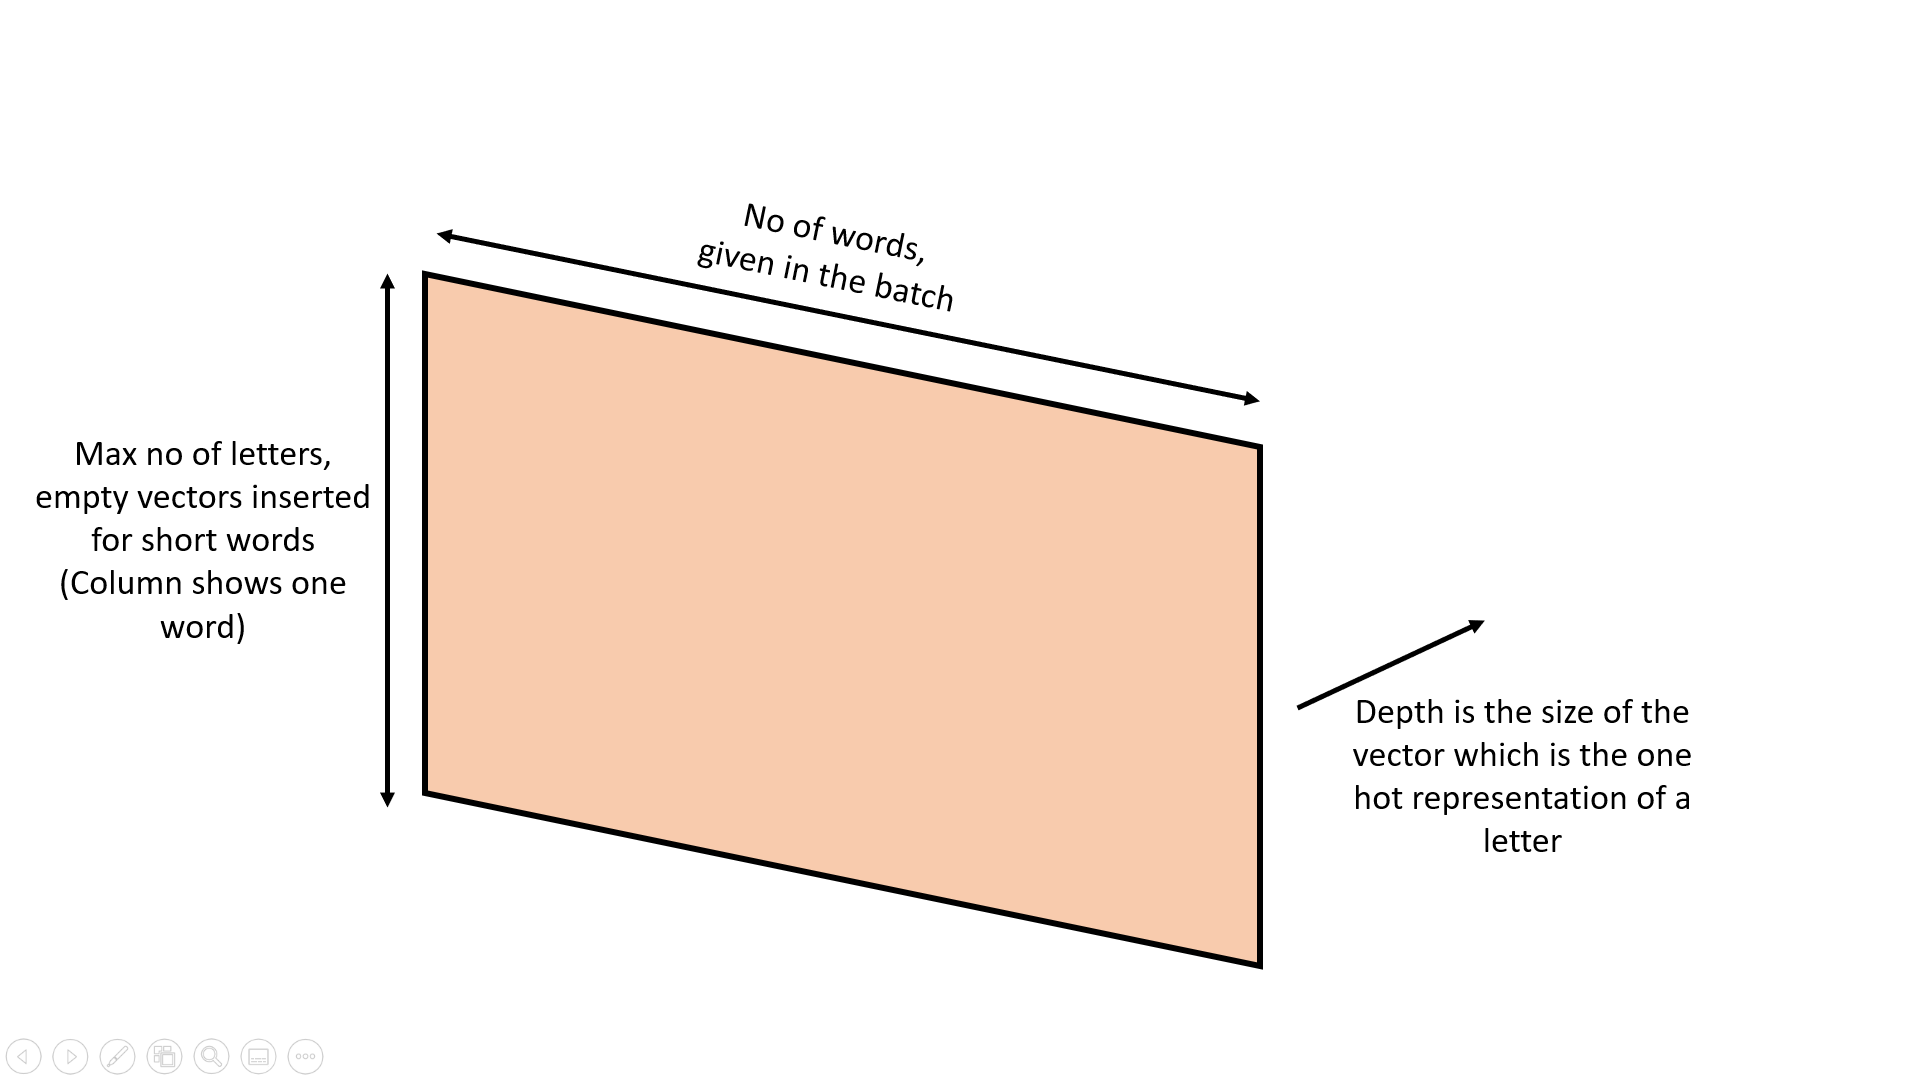

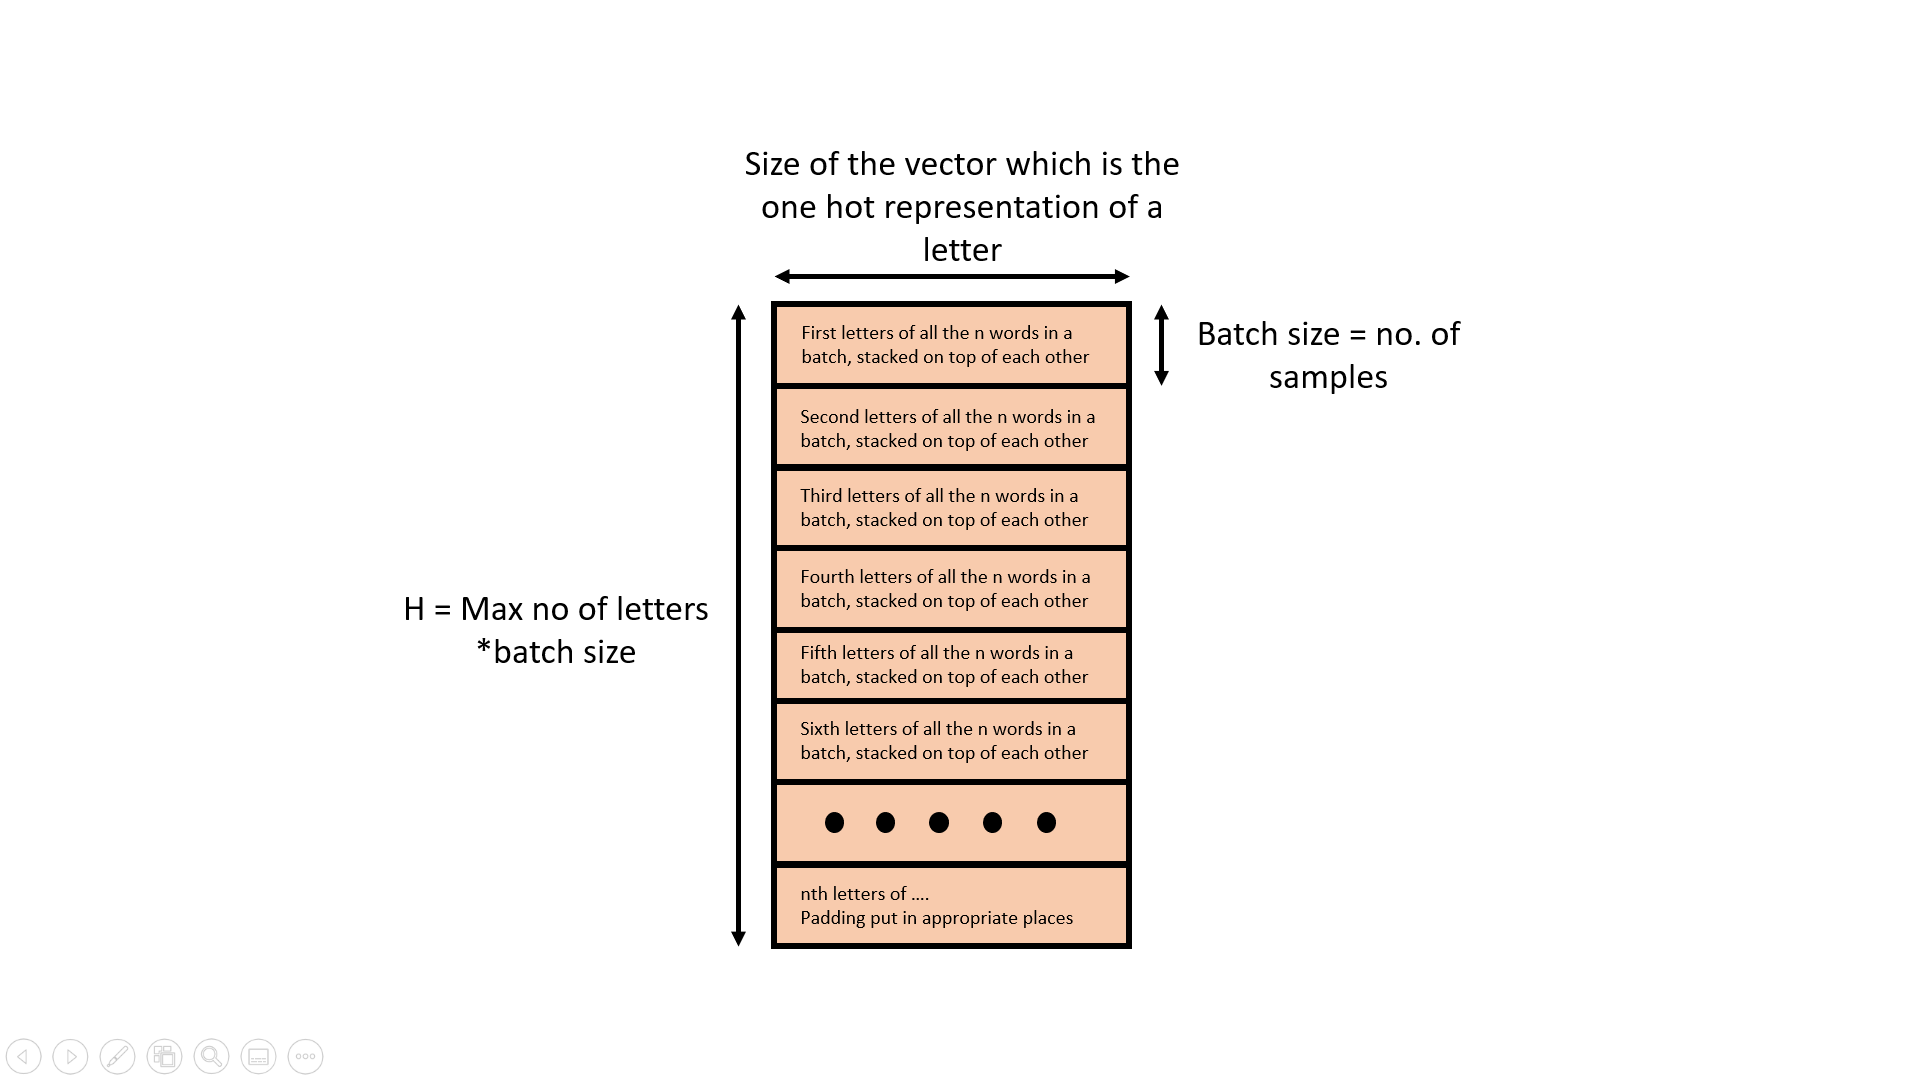

In [ ]:
def form_equal_words_batch_single_tensor(batch_in_list):
  max = 0
  for word in batch_in_list:
    if word.shape[0] > max:
      max = word.shape[0]
  # print('Max no of letters are',max)
  tensor_to_return = torch.zeros([max,len(batch_in_list),batch_in_list[0].shape[2]])
  for i,word in enumerate(batch_in_list):
    for j in range(word.shape[0]):
      tensor_to_return[j][i] = word[j]

  return tensor_to_return

#This function is explained above, and returns data as shown in the  first figure

In [ ]:
result = form_equal_words_batch_single_tensor(X_train_new)

In [ ]:
result.shape

torch.Size([19, 16040, 56])

In [ ]:
def convert_one_hot_to_letter(vector):
  index = torch.argmax(vector).item()
  return all_letters[index]

def convert_one_hot_to_word(word):
  return_str = ''
  for i in range(word.shape[0]):
    return_str += convert_one_hot_to_letter(word[i][0])
  return return_str

#Function to un-encode the data

In [ ]:
sample_list = (X_train_new[0],X_train_new[5])

In [ ]:
def visualize_stack(sample_list, list_form = True):
  if list_form == True:
    print('We have a batch of ', len(sample_list), 'words, which are')
    print(convert_one_hot_to_word(sample_list[0]))
    print(convert_one_hot_to_word(sample_list[1]))
    
    stack_data = form_equal_words_batch_single_tensor(sample_list)
    reshaping =  stack_data.view((stack_data.shape[0]*stack_data.shape[1]),stack_data.shape[2])
    print('Size of the stacked data is', reshaping.shape)
  else:
    reshaping = sample_list.data
  for i in range(reshaping.shape[0]):
    check = torch.sum(reshaping[i])
    if check == 0:
      print('<pad>')
    else:
      print(convert_one_hot_to_letter(reshaping[i]))

#The visualize stack function which helps to stack the data in the format above and visualize it

In [ ]:
visualize_stack(sample_list)

We have a batch of  2 words, which are
Abashkin
Jukes
Size of the stacked data is torch.Size([16, 56])
A
J
b
u
a
k
s
e
h
s
k
<pad>
i
<pad>
n
<pad>


In [ ]:
def generate_stacked_batch(n_points,X,Y, show_stats= False):
  X_list = []
  Y_list = []
  X_lengths = []
  for i in range(n_points):
    point = np.random.randint(len(X))
    X_list.append(X[point])
    Y_list.append(Y[point])
    X_lengths.append(X[point].shape[0])
  
  intermediate_X_batch = form_equal_words_batch_single_tensor(X_list)
  Y_batch = torch.tensor(Y_list)

  X_batch = torch.nn.utils.rnn.pack_padded_sequence(intermediate_X_batch,X_lengths,enforce_sorted=False)

  if show_stats == True:
    print('This is what our function created')
    print(intermediate_X_batch.shape)
    print('This is what our function stacked')
    print(visualize_stack(X_list))
    print('This is what pytorch made')
    print(X_batch.data.shape)
    print(visualize_stack(X_batch,list_form=False))
    
  return X_batch, Y_batch
    
#The final function, which creates the data that will be input to the RNN

In [ ]:
X_batch, Y_batch = generate_stacked_batch(2,X_train_new,Y_train_new,show_stats=True)

#Unnecessary padding removed

This is what our function created
torch.Size([8, 2, 56])
This is what our function stacked
We have a batch of  2 words, which are
Tukmanov
Rickett
Size of the stacked data is torch.Size([16, 56])
T
R
u
i
k
c
m
k
a
e
n
t
o
t
v
<pad>
None
This is what pytorch made
torch.Size([15, 56])
T
R
u
i
k
c
m
k
a
e
n
t
o
t
v
None


In [ ]:
class RNN_1_batched(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_1_batched,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size)
    self.i_t_o = nn.Linear(hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,hidden_val, batch_size = 1):
    out, hidden_val = self.rnn(input_val, hidden_val) 
    output = self.i_t_o(hidden_val)
    # output_val_2 = self.softmax(output_val_2)
    return output, hidden_val
  

  def new_hidden(self, batch_size = 1):
    hidden_val = torch.zeros(1,batch_size,self.hidden_size)
    return hidden_val

#Batching RNN, new_hidden also contains a batch_size now

In [ ]:
def train_one_batch_batched(model, points, loss_func, optimizer):

  optimizer.zero_grad()
  X_batch,Y_batch = generate_stacked_batch(points,X_train_new,Y_train_new)
  # print(X_batch.data.shape)
  # print(Y_batch.shape)
  hidden = model.new_hidden(batch_size = points)

  output, hidden = model.forward_pass(X_batch, hidden, batch_size=points)
  # print(hidden[0].shape)
  # print(output.shape)
  loss = loss_func(output.squeeze(),Y_batch)
  loss.backward()
    
  clipping_value = 100
  torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)

  optimizer.step()

  return loss

#Function for training a single batch, similar to earlier

In [ ]:
def accuracy_on_batched(model, points,k, X,Y):
  X_batch, Y_batch = generate_stacked_batch(points,X,Y)
  count = 0
  model.eval()
  hidden = net.new_hidden(batch_size=points)

  model_prediction, _ = net.forward_pass(X_batch,hidden,batch_size=points)
  output = model_prediction.squeeze()
  for i, word in enumerate(output):
    _, indices = word.topk(k)
    for index in indices:
      if index.item() == Y_batch[i].item():
        count+=1
  

  calc_accuracy = count/points
  return calc_accuracy

#Accuracy calculation with batched data

In [ ]:
net = RNN_1_batched(56,128,18)
loss_func = nn.CrossEntropyLoss()
opt= optim.SGD(net.parameters(), lr = 0.0005, momentum=0.9)

#Setting up our model

In [ ]:
%%time
train_one_batch_batched(net,256,loss_func,opt)

CPU times: user 36 ms, sys: 1.96 ms, total: 37.9 ms
Wall time: 64.9 ms


tensor(2.8469, grad_fn=<NllLossBackward>)

In [ ]:
def train_full_batched(model, no_batches, batch_size, lr, momentum=0.9):

  loss_array = torch.zeros(no_batches+1)
  loss_func = nn.CrossEntropyLoss()
  opt = optim.SGD(model.parameters(),lr=lr,momentum=momentum)

  for i in tqdm_notebook(range(no_batches)):
    loss_array[i+1] = (loss_array[i]*i + train_one_batch_batched(model,batch_size,loss_func,opt))/(i+1)
    if i%20 ==0:
      print('Calculated Accuracy')
      print('Top-1:', accuracy_on_batched(model, len(X_test_new),1,X_test_new,Y_test_new))
      print('Top-2:', accuracy_on_batched(model, len(X_test_new),2,X_test_new,Y_test_new))
      print('Loss: ', loss_array[i+1].item())
  
  return loss_array

#Train full function, same as earlier

In [ ]:
output = train_full_batched(net,5000,512,0.15,0.9)

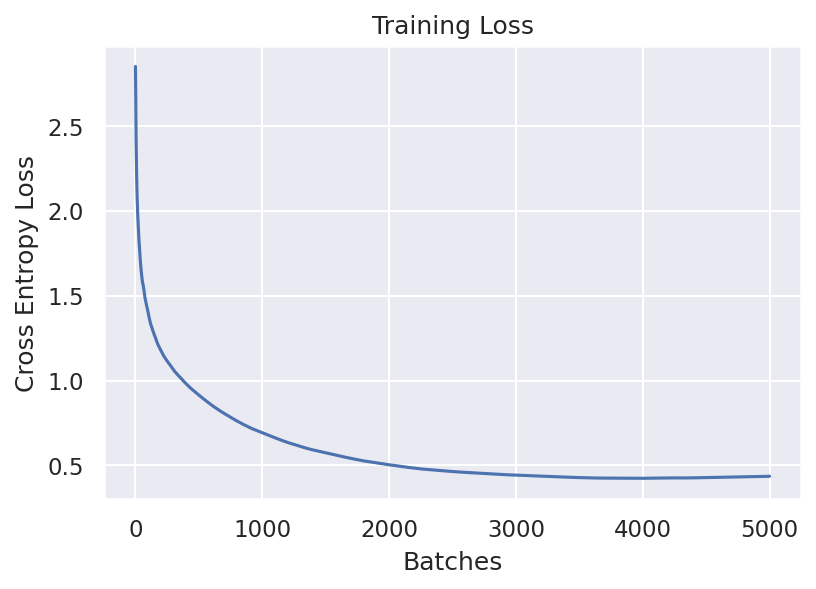

In [ ]:
plt.figure(dpi=150)
plt.plot(output.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
torch.save(net.state_dict(),'Trained_model_RNN_batch2.pth')

In [ ]:
state_dict = torch.load('Trained_model_RNN_batch2.pth')
net.load_state_dict(state_dict)
accuracy_on_batched(net,len(X_test_new),2,X_test_new,Y_test_new)

0.8586034912718205

In [ ]:
class LSTM_1_batch(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM_1_batch,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.do_lstm = nn.LSTM(input_size,hidden_size)
    self.i_t_o = nn.Linear(hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,h_state_s_state,batch_size = 1):
    output, h_state_s_state = self.do_lstm(input_val,h_state_s_state)
    output_val = self.i_t_o(h_state_s_state[0])
    # output_val_2 = self.softmax(output_val_2)
    return output_val, h_state_s_state

  def new_hidden(self,batch_size = 1):
    return (torch.zeros(1,batch_size,self.hidden_size), torch.zeros(1,batch_size,self.hidden_size))

#LSTM with batching

In [ ]:
net_lstm_batched = LSTM_1_batch(56,128,18)
loss_func = nn.CrossEntropyLoss()
opt= optim.SGD(net_lstm_batched.parameters(), lr = 0.15, momentum=0.9)

In [ ]:
output = train_full_batched(net_lstm_batched,5000,512,0.15,0.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Calculated Accuracy
Top-1: 0.7543640897755611
Top-2: 0.8553615960099751
Loss:  2.892686128616333
Calculated Accuracy
Top-1: 0.7538653366583541
Top-2: 0.8516209476309227
Loss:  2.190152406692505
Calculated Accuracy
Top-1: 0.7640897755610973
Top-2: 0.8618453865336658
Loss:  2.0260114669799805
Calculated Accuracy
Top-1: 0.755860349127182
Top-2: 0.8673316708229426
Loss:  1.9346628189086914
Calculated Accuracy
Top-1: 0.7536159600997506
Top-2: 0.8670822942643391
Loss:  1.8484721183776855
Calculated Accuracy
Top-1: 0.7755610972568578
Top-2: 0.8645885286783043
Loss:  1.7762291431427002
Calculated Accuracy
Top-1: 0.7563591022443891
Top-2: 0.8533665835411471
Loss:  1.7176108360290527
Calculated Accuracy
Top-1: 0.7593516209476309
Top-2: 0.8536159600997506
Loss:  1.6673555374145508
Calculated Accuracy
Top-1: 0.7685785536159601
Top-2: 0.8633416458852868
Loss:  1.6226677894592285
Calculated Accuracy
Top-1: 0.7653366583541147
Top-2: 0.8528678304239401
Loss:  1.5821964740753174
Calculated Accuracy
Top

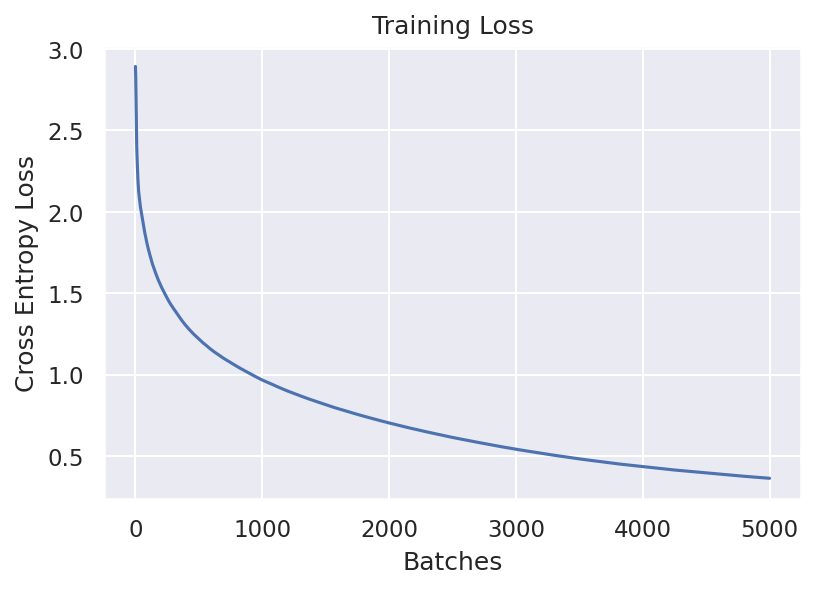

In [ ]:
plt.figure(dpi=150)
plt.plot(output.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
torch.save(net_lstm_batched.state_dict(),'Trained_model_LSTM_batch.pth')

In [ ]:
state_dict = torch.load('Trained_model_LSTM_batch.pth')
net_lstm_batched.load_state_dict(state_dict)
accuracy_on_batched(net_lstm_batched,len(X_test_new),2,X_test_new,Y_test_new)

0.8581047381546134

In [ ]:
class GRU_1_batched(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRU_1_batched,self).__init__()  #Check this 
    self.hidden_size = hidden_size
    self.do_gru = nn.GRU(input_size,hidden_size)
    self.i_t_o = nn.Linear(hidden_size, output_size)
    # self.softmax = nn.LogSoftmax(dim=1)
  
  def forward_pass(self,input_val,h_state, batch_size = 1):
    output, h_state = self.do_gru(input_val,h_state)
    output_val = self.i_t_o(h_state[0])
    # output_val_2 = self.softmax(output_val_2)
    return output_val, h_state

  def new_hidden(self, batch_size=1):
    return torch.zeros(1,batch_size,self.hidden_size)
    
#GRU with batching

In [ ]:
net_gru_batched = GRU_1_batched(56,128,18)
loss_func = nn.CrossEntropyLoss()
opt= optim.SGD(net_gru_batched.parameters(), lr = 0.15, momentum=0.9)

In [ ]:
output = train_full_batched(net_gru_batched,5000,512,0.15,0.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Calculated Accuracy
Top-1: 0.7663341645885287
Top-2: 0.8561097256857856
Loss:  2.8360366821289062
Calculated Accuracy
Top-1: 0.7581047381546134
Top-2: 0.8546134663341646
Loss:  2.068692922592163
Calculated Accuracy
Top-1: 0.7600997506234414
Top-2: 0.8581047381546134
Loss:  1.87666916847229
Calculated Accuracy
Top-1: 0.7463840399002494
Top-2: 0.8571072319201996
Loss:  1.755555272102356
Calculated Accuracy
Top-1: 0.7623441396508728
Top-2: 0.8518703241895261
Loss:  1.6607502698898315
Calculated Accuracy
Top-1: 0.7523690773067332
Top-2: 0.8658354114713217
Loss:  1.586925745010376
Calculated Accuracy
Top-1: 0.7685785536159601
Top-2: 0.856359102244389
Loss:  1.5292381048202515
Calculated Accuracy
Top-1: 0.7548628428927681
Top-2: 0.854862842892768
Loss:  1.4800703525543213
Calculated Accuracy
Top-1: 0.7591022443890274
Top-2: 0.8543640897755611
Loss:  1.4377821683883667
Calculated Accuracy
Top-1: 0.7526184538653367
Top-2: 0.8613466334164589
Loss:  1.3993195295333862
Calculated Accuracy
Top-1: 

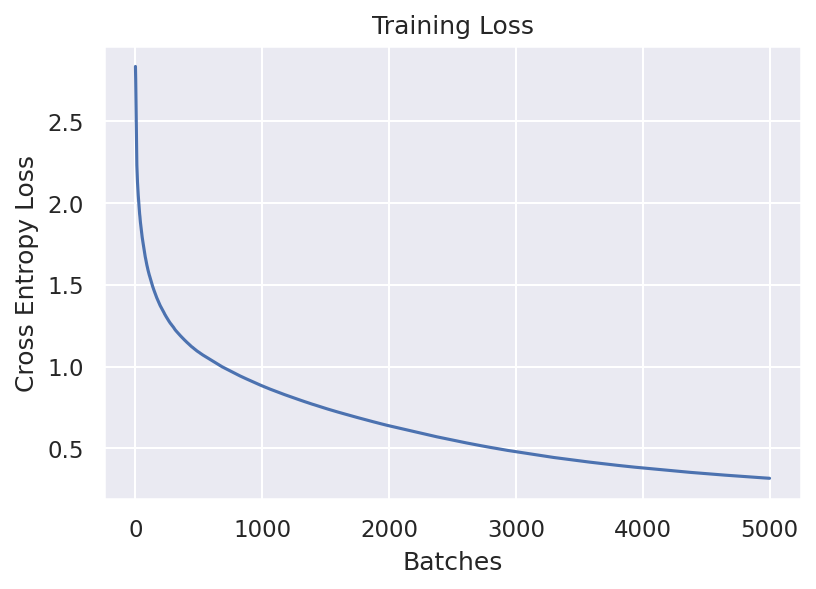

In [ ]:
plt.figure(dpi=150)
plt.plot(output.detach().numpy()[1:])
plt.xlabel('Batches')
plt.ylabel('Cross Entropy Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
torch.save(net_gru_batched.state_dict(),'Trained_model_GRU_batch.pth')

In [ ]:
state_dict = torch.load('Trained_model_GRU_batch.pth')
net_gru_batched.load_state_dict(state_dict)
accuracy_on_batched(net_gru_batched,len(X_test_new),2,X_test_new,Y_test_new)

0.8553615960099751